## TODO DEBS data

In [494]:
import pandas as pd
import numpy as np
import altair as alt

#pip install vega
#jupyter nbextension install --sys-prefix --py vega

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [547]:
import requests

host = 'http://localhost:8080/api'


def run_test(count, target='event-store'):
    query = { "batchSize": count }
    response = requests.request('GET', f'{host}/sys-info/performance/measure/{target}/insert-events/{count}', params=query)
    return response.json()

def clear_stream(stream='demo-event-store', target='event-store'):
    response = requests.request('DELETE', f'{host}/{target}/streams/{stream}/events')
    token = response.json()
    print(token)
    response = requests.request('POST', f'{host}/{target}/clear-request-confirmation', json=token)
    return response

In [560]:
clear_stream('demo_event_store', target='event-store/embedded')

{'streamName': 'demo_event_store', 'token': 'mDaWwICjDCqp3lpx6LxOp3iVh-6M62eM'}


<Response [200]>

In [514]:
# TODO test on non-replicated chronicle db and compare

# To create streams in the embedded db
def create_schema_for_embedded_db(schema):
    response = requests.request('POST', f'{host}/event-store/embedded/streams', json=schema)
    return response

In [556]:
create_schema_for_embedded_db({
    "streamName": "demo_event_store",
    "schema": [
        {
            "name": "SYMBOL",
            "type": "STRING",
            "properties": {}
        },
        {
            "name": "SECURITYTYPE",
            "type": "INTEGER",
            "properties": {}
        },
        {
            "name": "LASTTRADEPRICE",
            "type": "FLOAT",
            "properties": {}
        }
    ]
})

<Response [500]>

In [561]:
import datetime
import pandas as pd

def run_tests(counts=[1,100], trials_per_count=1, env_info={}, target='event-store', stream='demo-event-store'):
    now = datetime.datetime.now().replace(microsecond=0).isoformat().replace(':', '-')
    csv_name = f'results-{now}.csv'
    
    env_info_columns = list(env_info.keys())
    
    df = pd.DataFrame(columns = [*env_info_columns, 'buffer_size_in_bytes', 'event_count', 'trial', 'duration_in_ms', 'measured_on'])
    
    for count in counts:
        for i in range(0, trials_per_count):
            print(f'Trial {i+1} for event count {count}')
            results = run_test(count, target)
            print(results['message'])       
            df = df.append({
                **env_info,
                'buffer_size_in_bytes': results['bufferSize'], 
                'trial': i+1, 
                'event_count': count, 
                'duration_in_ms': results['timeElapsed'],                 
                'measured_on': now
            }, ignore_index=True)
            df.to_csv(f'measurements/{csv_name}', index=False)                 
            # clean service after each trial. Must delete all events to avoid OOO
            stream_cleared = clear_stream(stream, target)
            print(stream_cleared)            
            
    return df

In [26]:
clear_stream()

<Response [200]>

In [520]:
env_info = {
    'cluster_type': 'localI7', 
    'node_count': 3, 
    'event_type': 'randomized', 
    'buffer_type': 'none'
}

run_tests(counts=[1, 100, 10000, 1000000], trials_per_count=10, env_info=env_info, target='event-store')

# run_tests(counts=[10000000], trials_per_count=10, env_info=env_info)

# an event of our examples has ~21 bytes

Trial 1 for event count 1
runInsertIntoEventStoreMeasurements 1 times in 1 batches (1 threads per batch)
Batch 1: Inserted events 1 times s; ~1ms per call]
Total time: 22ms

<Response [200]>
Trial 2 for event count 1


KeyboardInterrupt: 

In [ ]:
# measure performance of non-replicated, embedded store (the original one)

env_info = {
    'cluster_type': 'standalone-embedded', 
    'node_count': 1, 
    'event_type': 'randomized', 
    'buffer_type': 'none-embedded'
}

# TODO delete not working atm, causes OOO

run_tests(counts=[1, 100, 10000, 1000000], trials_per_count=10, env_info=env_info, target='event-store/embedded', stream='demo_event_store')

In [23]:
# TODO we actually don't know how long the insert is in total as we are async as soon as events are offered to the buffer-
# So, as we are waiting for buffer flushes, but not the last flush, we miss the time it tooks to apply the last flushed buffer
# TODO therefore need some callback in event store to know when the store is done, not just the buffer...
# example: Inserted events 10000 times asynchronously [45ms] <-- this is just the time it takes to insert them into the in-mem buffer!
# -> at least 4.5 sec for 1mio events to put into the buffer

# -> raft log entry size is limited! ->  # Log entry size 13383315 exceeds the max buffer limit of 4194304
# raft.server.log.appender.buffer.byte-limit = 4MB

In [ ]:
# TODO test with maximum size buffer

In [ ]:
# TODO test with raft log entries not persisted

## Evaluating the benchmark results

⚠ All of this is currently under conditions without out-of-order events

In [576]:
# load all measurements

from os import walk

resource_folder = 'measurements'

resources = next(walk(resource_folder), (None, None, []))[2]

print(f'{len(resources)} files in total')

13 files in total


In [577]:
datasets = {filename: pd.read_csv(f'{resource_folder}/{filename}', sep=',', encoding='utf-8', error_bad_lines=False) for filename in resources}

In [578]:
all_measurements_df = pd.concat(datasets, ignore_index=True)

all_measurements_df

,cluster_type,node_count,event_type,buffer_type,buffer_size_in_bytes,event_count,trial,duration_in_ms,measured_on
0,localI7,3,randomized,blocking,10240,1,1,1,2022-01-29T12-48-43
1,localI7,3,randomized,blocking,10240,1,2,0,2022-01-29T12-48-43
2,localI7,3,randomized,blocking,10240,1,3,2,2022-01-29T12-48-43
3,localI7,3,randomized,blocking,10240,1,4,0,2022-01-29T12-48-43
4,localI7,3,randomized,blocking,10240,1,5,1,2022-01-29T12-48-43
...,...,...,...,...,...,...,...,...,...
438,standalone-embedded,1,randomized,none-embedded,0,1000000,6,626,2022-01-30T21-55-11
439,standalone-embedded,1,randomized,none-embedded,0,1000000,7,569,2022-01-30T21-55-11
440,standalone-embedded,1,randomized,none-embedded,0,1000000,8,613,2022-01-30T21-55-11
441,standalone-embedded,1,randomized,none-embedded,0,1000000,9,762,2022-01-30T21-55-11


In [579]:
# supress warnings
pd.options.mode.chained_assignment = None

# remove rows with duration = 0 to avoid divide by zero
all_measurements_df = all_measurements_df[all_measurements_df['duration_in_ms'] > 0]

# replace buffer_size 0 with 1 to allow log scale plotting
all_measurements_df.loc[all_measurements_df['buffer_size_in_bytes'] == 0, 'buffer_size_in_bytes'] = 1

all_measurements_df['duration_per_event'] = all_measurements_df['duration_in_ms'] / all_measurements_df['event_count']
all_measurements_df['duration_per_mio_events'] = all_measurements_df['duration_per_event'] * 1000000
all_measurements_df['duration_per_mio_events_in_sec'] = all_measurements_df['duration_per_mio_events'] / 1000
all_measurements_df['events_per_second'] = 1000 / all_measurements_df['duration_per_event']

pd.options.mode.chained_assignment = 'warn'

all_measurements_df.describe()

,node_count,buffer_size_in_bytes,event_count,trial,duration_in_ms,duration_per_event,duration_per_mio_events,duration_per_mio_events_in_sec,events_per_second
count,396.000000,3.960000e+02,3.960000e+02,396.000000,396.000000,396.000000,3.960000e+02,396.000000,3.960000e+02
mean,2.828283,3.436737e+05,5.154292e+05,5.404040,24444.790404,2.178244,2.178244e+06,2178.243611,1.123642e+05
std,0.561019,4.723513e+05,1.589369e+06,2.917149,82933.459069,7.398387,7.398387e+06,7398.386956,2.497913e+05
min,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,0.000563,5.630000e+02,0.563000,1.162791e+01
25%,3.000000,1.024000e+03,1.000000e+02,3.000000,3.000000,0.010000,1.000000e+04,10.000000,2.153349e+03
50%,3.000000,1.024000e+04,1.000000e+04,5.000000,42.000000,0.020332,2.033200e+04,20.332000,4.918367e+04
75%,3.000000,1.048576e+06,1.000000e+06,8.000000,9292.750000,0.464517,4.645168e+05,464.516750,1.000000e+05
max,3.000000,1.048576e+06,1.000000e+07,10.000000,485271.000000,86.000000,8.600000e+07,86000.000000,1.776199e+06


In [580]:
replicated_measurements_df = all_measurements_df[all_measurements_df['cluster_type'] != 'standalone-embedded']
embedded_measurements_df = all_measurements_df[all_measurements_df['cluster_type'] == 'standalone-embedded']

In [693]:
import altair as alt

def plot_event_rate(df, title="Event Throughput Rates", show_benchmark=False, show_benchmark_at=10000000, aggregate='median'):    
    buffer_size_label_expr = "datum.label && datum.label[0] == '1' ? (datum.value >= 1000000 ? datum.value / 1000000 + ' MB' : datum.value >= 1000 ? datum.value / 1000 + ' KB' : datum.label + ' B') : null"    
    if show_benchmark:
        buffer_size_label_expr = f'datum.value == {show_benchmark_at} ? "Standalone" : ({buffer_size_label_expr})'

    blocking_queue_event_rate_plot = alt.Chart(df).mark_bar(clip=True, width=15).encode(
        x=alt.X('buffer_size_in_bytes:Q', scale=alt.Scale(type='log'), title="Buffer Size (in Bytes, Log Scale)", axis=alt.Axis(        
            labelExpr=buffer_size_label_expr
        )),
        y=alt.Y(f'{aggregate}(events_per_second):Q', title=f"{aggregate.capitalize()} of Events/sec", scale=alt.Scale(padding=1)),
        color=alt.condition(
            alt.datum.buffer_size_in_bytes == show_benchmark_at,
            alt.value('#919eac'),
            alt.value('#4c78a8')            
        )
    ).properties(width=300, height=300, title=title)

    return blocking_queue_event_rate_plot + blocking_queue_event_rate_plot.mark_text(
        align='center',
        color='black',
        dx=0,
        dy=-8
    ).encode(
        text=alt.Text(f'{aggregate}(events_per_second):Q', format=',.0f'),
        color=alt.value('black')
    ).transform_calculate(label='datum.y + " inches"')

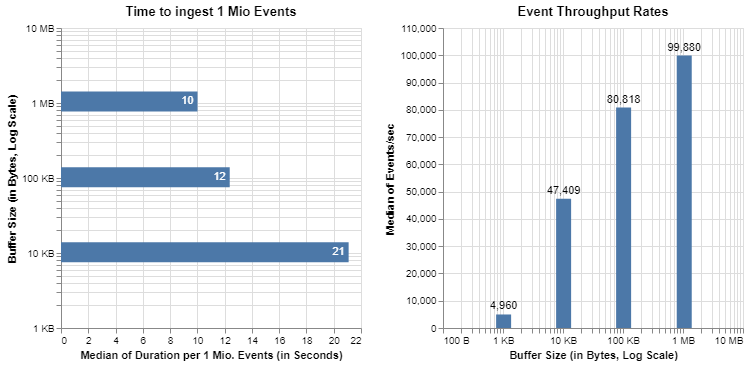

In [694]:
buffer_size_label_expr = "datum.label && datum.label[0] == '1' ? (datum.value >= 1000000 ? datum.value / 1000000 + ' MB' : datum.value >= 1000 ? datum.value / 1000 + ' KB' : datum.label + ' B') : null"

duration_plot = alt.Chart(replicated_measurements_df[replicated_measurements_df['buffer_size_in_bytes'] > 1048]).mark_bar(clip=True, height=20).encode(
    x=alt.X('median(duration_per_mio_events_in_sec):Q', title="Median of Duration per 1 Mio. Events (in Seconds)"),
    y=alt.Y('buffer_size_in_bytes:Q', scale=alt.Scale(type='log'), title="Buffer Size (in Bytes, Log Scale)", axis=alt.Axis(        
        labelExpr=buffer_size_label_expr
    )),
).properties(width=300, title="Time to ingest 1 Mio Events")

duration_plot = duration_plot + duration_plot.mark_text(
    align='right',
    color='white',
    dx=-4,
    #dy=-18
).encode(
    text=alt.Text('median(duration_per_mio_events_in_sec):Q', format=',.0f'),
)

duration_plot | plot_event_rate(replicated_measurements_df[replicated_measurements_df['buffer_size_in_bytes'] > 1])

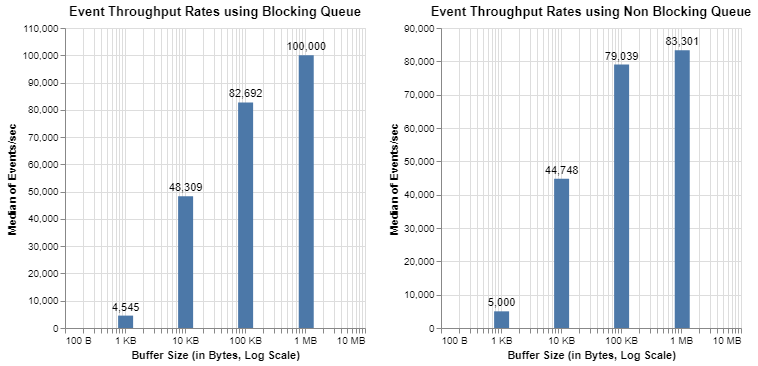

In [684]:
blocking_queue_df = replicated_measurements_df[replicated_measurements_df['buffer_type'] == 'blocking']
non_blocking_queue_df = replicated_measurements_df[replicated_measurements_df['buffer_type'] == 'non-blocking']

plot_event_rate(blocking_queue_df, title="Event Throughput Rates using Blocking Queue") | plot_event_rate(non_blocking_queue_df, title="Event Throughput Rates using Non Blocking Queue")

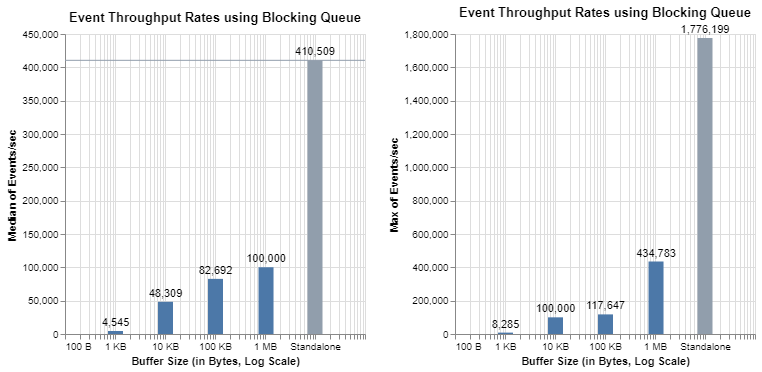

In [695]:
blocking_queue_vs_standalone_df = all_measurements_df[(all_measurements_df['buffer_type'] == 'blocking') | (all_measurements_df['buffer_type'] == 'none-embedded')]

show_benchmark_at = 10000000

blocking_queue_vs_standalone_df.loc[(blocking_queue_vs_standalone_df['buffer_type'] == 'none-embedded'), 'buffer_size_in_bytes'] = show_benchmark_at

median_plot = plot_event_rate(blocking_queue_vs_standalone_df, title="Event Throughput Rates using Blocking Queue", show_benchmark=True, show_benchmark_at=show_benchmark_at, aggregate="median")
max_plot = plot_event_rate(blocking_queue_vs_standalone_df, title="Event Throughput Rates using Blocking Queue", show_benchmark=True, show_benchmark_at=show_benchmark_at, aggregate="max")

benchmark_score = all_measurements_df[all_measurements_df['buffer_type'] == 'none-embedded']['events_per_second'].median()

median_plot + alt.Chart(pd.DataFrame({'y': [benchmark_score]})).mark_rule(color="#919eac").encode(y='y') | max_plot

# a = plot_event_rate(all_measurements_df[(all_measurements_df['buffer_type'] == 'blocking')], title="Event Throughput Rates using Blocking Queue", show_benchmark=True, show_benchmark_at=show_benchmark_at, aggregate="median") 
# b = plot_event_rate(all_measurements_df[(all_measurements_df['buffer_type'] == 'none-embedded')], title="Event Throughput Rates using Blocking Queue", show_benchmark=True, show_benchmark_at=1, aggregate="median") 

# a + b

## TODO compare different number of nodes!

## Comparison of Blocking vs Non-Blocking Buffer

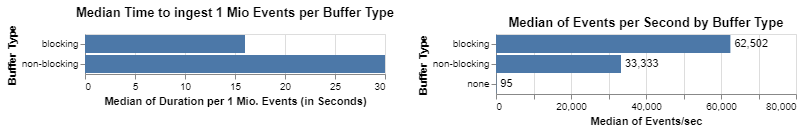

In [643]:
buffered_measurements_df = replicated_measurements_df[replicated_measurements_df['buffer_type'] != 'none']

time_per_buffer_plot = alt.Chart(buffered_measurements_df).mark_bar(clip=True).encode(
    x=alt.X('median(duration_per_mio_events_in_sec):Q', title="Median of Duration per 1 Mio. Events (in Seconds)"),
    y=alt.Y('buffer_type:N',title="Buffer Type"),
).properties(width=300, title="Median Time to ingest 1 Mio Events per Buffer Type")

events_per_sec_plot = alt.Chart(replicated_measurements_df).mark_bar(clip=True).encode(
    x=alt.X('median(events_per_second):Q', title="Median of Events/sec", scale=alt.Scale(domain=[0, 80000])),
    y=alt.Y('buffer_type:N',title="Buffer Type"),
).properties(width=300, title="Median of Events per Second by Buffer Type")


events_per_sec_plot = events_per_sec_plot + events_per_sec_plot.mark_text(
    align='left',
    color='black',
    dx=4,
    #dy=-18
).encode(
    text=alt.Text('median(events_per_second):Q', format=',.0f'),
)

time_per_buffer_plot | events_per_sec_plot

### Comparison with Standalone/Embedded ChronicleDB

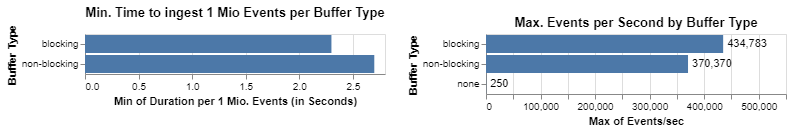

In [641]:
time_per_buffer_plot = alt.Chart(buffered_measurements_df).mark_bar(clip=True).encode(
    x=alt.X('min(duration_per_mio_events_in_sec):Q', title="Min of Duration per 1 Mio. Events (in Seconds)"),
    y=alt.Y('buffer_type:N',title="Buffer Type"),
).properties(width=300, title="Min. Time to ingest 1 Mio Events per Buffer Type")

events_per_sec_plot = alt.Chart(replicated_measurements_df).mark_bar(clip=True).encode(
    x=alt.X('max(events_per_second):Q', title="Max of Events/sec", scale=alt.Scale(domain=[0, 550000])),
    y=alt.Y('buffer_type:N',title="Buffer Type"),
).properties(width=300, title="Max. Events per Second by Buffer Type")


events_per_sec_plot = events_per_sec_plot + events_per_sec_plot.mark_text(
    align='left',
    color='black',
    dx=4,
    #dy=-18
).encode(
    text=alt.Text('max(events_per_second):Q', format=',.0f'),
)

time_per_buffer_plot | events_per_sec_plot

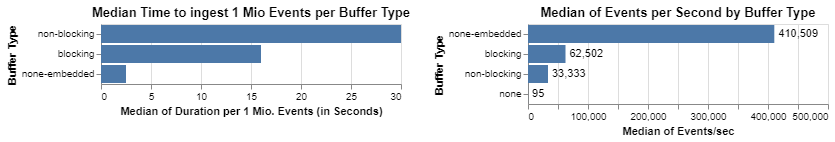

In [644]:
buffered_and_embedded_measurements_df = all_measurements_df[all_measurements_df['buffer_type'] != 'none']

time_per_buffer_plot = alt.Chart(buffered_and_embedded_measurements_df).mark_bar(clip=True).encode(
    x=alt.X('median(duration_per_mio_events_in_sec):Q', title="Median of Duration per 1 Mio. Events (in Seconds)"),
    y=alt.Y('buffer_type:N',title="Buffer Type", sort='-x'),
).properties(width=300, title="Median Time to ingest 1 Mio Events per Buffer Type")

events_per_sec_plot = alt.Chart(all_measurements_df).mark_bar(clip=True).encode(
    x=alt.X('median(events_per_second):Q', title="Median of Events/sec", scale=alt.Scale(domain=[0, 500000])),
    y=alt.Y('buffer_type:N',title="Buffer Type", sort='-x'),
).properties(width=300, title="Median of Events per Second by Buffer Type")


events_per_sec_plot = events_per_sec_plot + events_per_sec_plot.mark_text(
    align='left',
    color='black',
    dx=4,
    #dy=-18
).encode(
    text=alt.Text('median(events_per_second):Q', format=',.0f'),
)

time_per_buffer_plot | events_per_sec_plot

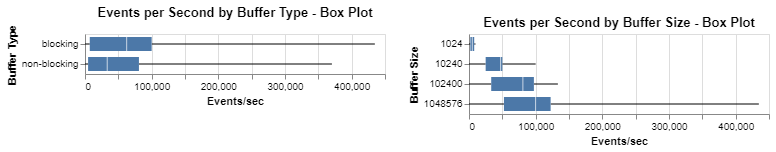

In [645]:
alt.Chart(buffered_measurements_df).mark_boxplot(extent='min-max').encode(
    y=alt.Y('buffer_type:N',title="Buffer Type"),
    x=alt.X('events_per_second:Q', title="Events/sec"),    
).properties(width=300, title="Events per Second by Buffer Type - Box Plot") | alt.Chart(buffered_measurements_df).mark_boxplot(extent='min-max').encode(
    y=alt.Y('buffer_size_in_bytes:O',title="Buffer Size"),
    x=alt.X('events_per_second:Q', title="Events/sec"),    
).properties(width=300, title="Events per Second by Buffer Size - Box Plot")

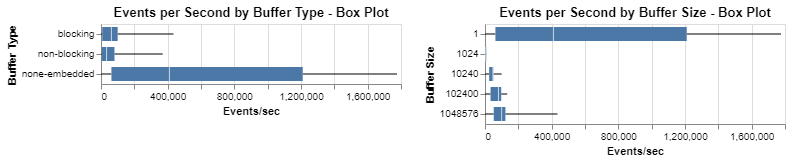

In [647]:
alt.Chart(buffered_and_embedded_measurements_df).mark_boxplot(extent='min-max').encode(
    y=alt.Y('buffer_type:N',title="Buffer Type"),
    x=alt.X('events_per_second:Q', title="Events/sec"),    
).properties(width=300, title="Events per Second by Buffer Type - Box Plot") | alt.Chart(buffered_and_embedded_measurements_df).mark_boxplot(extent='min-max').encode(
    y=alt.Y('buffer_size_in_bytes:O',title="Buffer Size"),
    x=alt.X('events_per_second:Q', title="Events/sec"),    
).properties(width=300, title="Events per Second by Buffer Size - Box Plot")

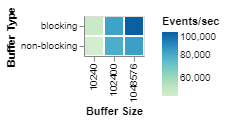

In [648]:
alt.Chart(replicated_measurements_df[replicated_measurements_df['buffer_size_in_bytes'] > 1024]).mark_bar(clip=True).encode(
    color=alt.Color('median(events_per_second):Q', title="Events/sec", scale=alt.Scale(scheme='greenblue')),
    x=alt.X('buffer_size_in_bytes:N',title="Buffer Size"),
    y=alt.Y('buffer_type:N',title="Buffer Type"),
).properties(title="")

Running the cluster without a buffer leads to 100% utilization of the machines IO, as in the current naive implementation of the raft log and state machine, each event is sent to all nodes, needs to be committed by at least a quorum of notes and is also written into the raft log of each node.